In [1]:
import yfinance as yf
import numpy as np

data = yf.download("VNQ SPY IEF", start="2010-01-01", end="2023-09-30")

[*********************100%***********************]  3 of 3 completed


In [2]:
import numpy as np
import statsmodels.api as sm

log_returns = np.log(data['Adj Close']).diff()
y_train = log_returns['VNQ'][1:3396]
y_test = log_returns['VNQ'][3396:]
X_train = log_returns[['SPY', 'IEF']][1:3396]
X_test = log_returns[['SPY', 'IEF']][3396:]

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)

model_summary = f"""
Number of observations: {X_train.shape[0]}
Training sample start: {X_train.index.min().strftime('%Y-%m-%d')}
Training sample end: {X_train.index.max().strftime('%Y-%m-%d')}
Estimated coefficients: {np.round(model.coef_,4)}
Estimated intercept: {np.round(model.intercept_,4)}
R-squared: {np.round(r2,4)}
Root Mean Squared Error: {np.round(rmse,4)}
Mean Absolute Error: {np.round(mae,4)}
"""

# model.coef_ = np.array([0.50, -0.50]) # overwriting the estimated parameters to test

In [4]:
print(model_summary)


Number of observations: 3395
Training sample start: 2010-01-05
Training sample end: 2023-06-30
Estimated coefficients: [0.9905 0.4677]
Estimated intercept: -0.0002
R-squared: 0.6179
Root Mean Squared Error: 0.0083
Mean Absolute Error: 0.0061



In [5]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [6]:
from typing import Annotated
from langchain_experimental.tools import PythonREPLTool, PythonAstREPLTool

python_repl_tool = PythonAstREPLTool(locals={"log_returns": log_returns})

In [7]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate
import functools
import operator
from typing import Sequence, TypedDict

system_prompt = """
You are backtesting a linear regression model in Python.
The model was estimated using LinearRegression with the sklearn library.
It is is available to load as needed in the pickle file `model.pkl`.
The dependent variable is named `VNQ`, the independent variables are named `SPY` and `IEF`.
The estimated model summary is:
{model_summary}
The in-sample and out-of-sample data is in the dataframe named `log_returns`.
It is important to understand the attributes of the dataframe before working with it. 
This is the result of running `log_returns.head().to_markdown()`
<df>
{datahead}
</df>
These rows are meant as a way of telling you about the shape and schema of the dataframe. 
You can run additional queries to perform additional analysis as needed. 
"""

system_prompt = system_prompt.format(datahead=log_returns.head().to_markdown(), model_summary=model_summary)

In [8]:
print(system_prompt)


You are backtesting a linear regression model in Python.
The model was estimated using LinearRegression with the sklearn library.
It is is available to load as needed in the pickle file `model.pkl`.
The dependent variable is named `VNQ`, the independent variables are named `SPY` and `IEF`.
The estimated model summary is:

Number of observations: 3395
Training sample start: 2010-01-05
Training sample end: 2023-06-30
Estimated coefficients: [0.9905 0.4677]
Estimated intercept: -0.0002
R-squared: 0.6179
Root Mean Squared Error: 0.0083
Mean Absolute Error: 0.0061

The in-sample and out-of-sample data is in the dataframe named `log_returns`.
It is important to understand the attributes of the dataframe before working with it. 
This is the result of running `log_returns.head().to_markdown()`
<df>
| Date                      |          IEF |           SPY |          VNQ |
|:--------------------------|-------------:|--------------:|-------------:|
| 2010-01-04 00:00:00+00:00 | nan          | 

In [9]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str # where to route to next

def create_agent(llm: ChatOpenAI, tools: list, task: str):
    prompt = ChatPromptTemplate.from_messages(
        [
            ( "system", system_prompt, ),
            HumanMessage(content=task),
            HumanMessage(content="The results from the analysis run so far are: "),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools) # verbose=True for debugging
    return executor

# AIMessage will have all kinds of metadata, bit of a hack to treat everything as HumanMessage
def agent_node(state: AgentState, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

def chain_node(state: AgentState, chain, name):
    result = chain.invoke(input={"detail": "medium", "messages": state["messages"]})
    return {"messages": [HumanMessage(content=result.content, name=name)]}

In [10]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", top_p=0.00001, seed=42424242) # trying to reduce randomness
llm_big = ChatOpenAI(model="gpt-4o", top_p=0.00001, seed=42424242)

In [11]:
backtest_task = """
Using the estimated model, summarize the out-of-sample errors starting after 2023-06-30.
Include the out-of-sample mean error, mean absolute error and the root mean squared error.
Note any outliers in the out-of-sample performance.
Compare the out-of-sample errors with the in-sample errors.
Are the out-of-sample errors consistent with the in-sample errors?
Generate a plot of the model's out-of-sample fit, display it and save it to `oos_fit.png`.
Generate a plot of the model's out-of-sample residuals vs. period, display it and save it to `resid.png`."""
backtest_agent = create_agent(llm, [python_repl_tool], task=backtest_task,)
backtest_node = functools.partial(agent_node, agent=backtest_agent, name="Backtest")

plot_template = ChatPromptTemplate.from_messages(
    messages=[
        ("system", system_prompt),
        HumanMessage(content="""These plots contain the out-of-sample fit and residuals for the model.
                    Review the out-of-sample fit plot, does the model fit the out-of-sample data well? 
                    Based on the out-of-sample error summary and the out-of-sample plots, should the model be re-fit?"""),
        MessagesPlaceholder(variable_name="messages"),
        HumanMessagePromptTemplate.from_template(
            template=[{"type": "image_url", "image_url": {"path": "oos_fit.png"}}, 
                      {"type": "image_url", "image_url": {"path": "resid.png"}}]),
    ]
)

refit_chain = plot_template | llm_big
refit_node = functools.partial(chain_node, chain=refit_chain, name="RefitDecision")

In [12]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Backtest", backtest_node)
workflow.add_node("RefitDecision", refit_node)

workflow.add_edge(START, "Backtest")
workflow.add_edge("Backtest", "RefitDecision")
workflow.add_edge("RefitDecision", END)

graph = workflow.compile()

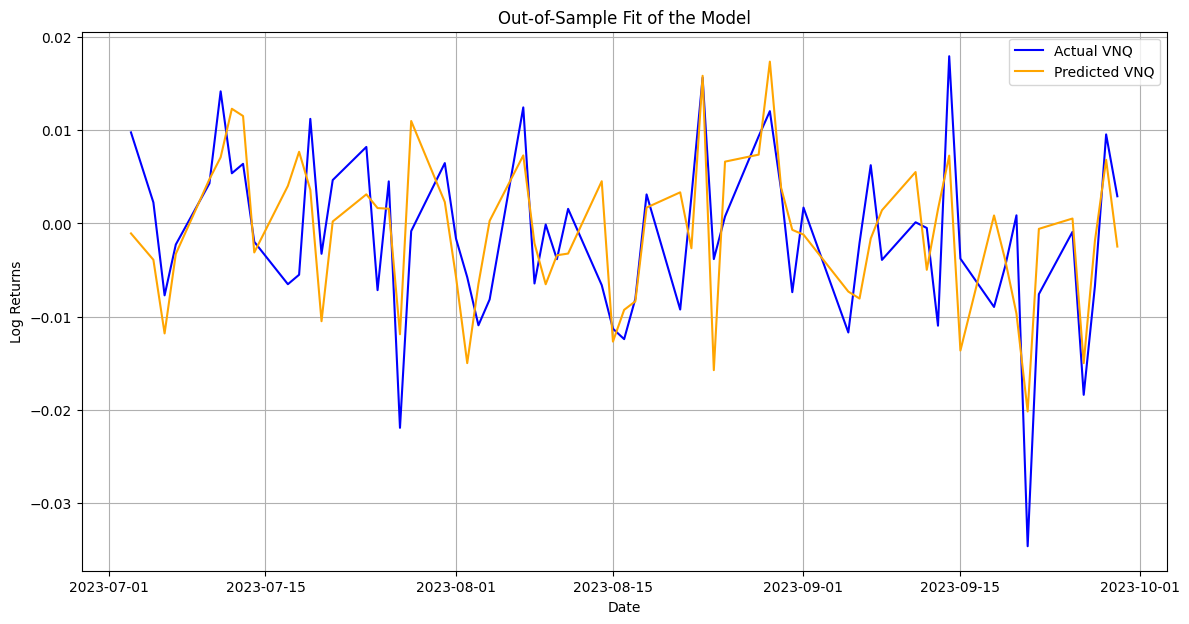

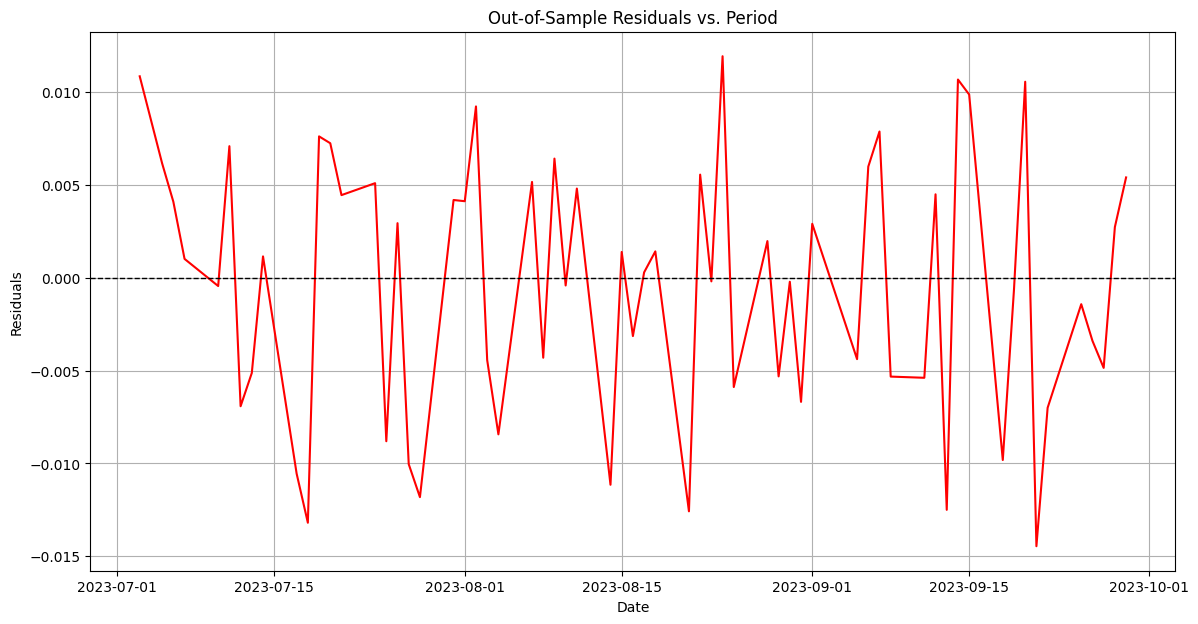

The analysis of the out-of-sample errors starting after 2023-06-30 has been completed. Here are the results:

### Out-of-Sample Error Summary
- **Mean Error**: -0.00039
- **Mean Absolute Error**: 0.00593
- **Root Mean Squared Error**: 0.00699
- **Number of Outliers**: 0

### Comparison with In-Sample Errors
- **In-Sample Mean Absolute Error**: 0.0061
- **In-Sample Root Mean Squared Error**: 0.0083

### Observations
- The out-of-sample mean error is slightly negative, indicating that the model tends to underpredict the actual values.
- The mean absolute error and root mean squared error in the out-of-sample data are lower than the in-sample errors, suggesting that the model performed better on the out-of-sample data.
- There were no outliers detected in the out-of-sample performance.

### Plots
The following plots have been generated:
1. **Out-of-Sample Fit of the Model**: This plot shows the actual vs. predicted values for VNQ.
2. **Out-of-Sample Residuals vs. Period**: This plot displ

In [13]:
input_message = {"messages": [HumanMessage(content="Run the analysis")]}
for chunk in graph.stream(input_message):
    print([c['messages'][0].content for c in chunk.values()][0])